# Training a Rubix Cube Solver via Reinforcement Learning

In [1]:
import os
import pickle
import sys
sys.path.append('..')

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lib.cube import Cube
from lib.solver import CubeSolver
from lib.models import CNN
from lib.utils import linear_decay_constant, exponential_decay, constant_rate

from IPython.display import Image, Markdown

%matplotlib inline

## Introduction 

### Setting problem up as a Markov Decision Process [1]

In this repo, an agent is trained to solve a Rubix Cube via deep Q-learning. In this approach, solving the Rubix Cube is modeled as a Markov Decision Process (MDP). A MDP is defined by the tuple ($S$,$A$,$P_{a}$,$R_{a}$). 

The set of states, $S$, is all possibles configurations of the Rubix Cube.

The set of actions, $A$, is the 12 possible movements of the cube ($F$, $R$, $U$, $L$, $B$, $D$, $F'$, $R'$, $U'$, $L'$, $B'$, $D'$). 

$P_{a}(s,s')=P(s_{t+1}=s'\mid s_{t}=s,a_{t}=a)$ is the probability that action $a$ in state $s$ at time $t$ will lead to state $s'$ at time $t+1$. In the case of the Rubix cube, each valid move changes the state of the cube in a deterministic way.

$R_{a}(s,s')$ is the immediate reward received after transitioning from state $s$ to state $s'$, due to action $a$. In this formulation of solving a Rubix cube a reward of 1 is recieved when an action leads to the cube being in a solved state, and 0 otherwise.


### Finding optimal actions in a Markov Decision Process [1]

At each time step, the agent tries to solve the cube by choosing an action (one of the 12 valid cube rotations)  based on the current state of cube.

In general, agents of an MDP make these decisions according to a policy: 

$\pi(s) = argmax_a {\sum_{s'} P(s'|s,a)(R(s'|s,a) + \gamma V(s')}$

where $\gamma$ is a discount factor between [0,1]

and $V(s) = \sum_{s'}P_{\pi(s)}(s,s')[R_{\pi(s)}(s,s') + \gamma V(s')]$ is a recursively defined value function that encodes the sum of all future expected rewards recieved by being in state $s$ and following the policy $\pi(s)$.

In relatively simple MDPs, an optimal policy $\pi^{*}(s)$ can be determined through an algorithm such as value iteration. 

However, in more complex MDPs, such as the Rubix cube case, an optimal policy can be approximated via reinforcement learning. Here, the action that an agent chooses given the current state is the action that maximizes a new function, known as the $Q$ function. The $Q$ function is defined generally as:

$Q(s,a) = \sum_{s'}P_{a}(s,s')[R_{a}(s,s') + \gamma max_{a'}Q(s',a')]$ 

which is seen to be similar to $\pi(s)$ except for the case where $V(s)$ is unknown. In the Rubix cube domain, the $Q$ function can be simplified since each action deterministically transisitions the cube to another state. The simplified $Q$ function is:

$Q(s,a) = R_{a}(s,s') + \gamma max_{a'}Q(s',a')$ where $s'$ is the state of the cube after action $a$

Since both the states and actions are discrete, the $Q$ function can also be thought of as an $|S| x |A|$ array of values. However, what makes the Rubix cube challenging is that there are 43,252,003,274,489,856,000 possible states of the cube! 

### Enter Deep Learning:

Since it is infeasible to to calculate or store a 43,252,003,274,489,856,000 x 12 look-up table, we instead have to find a way to approximate the $Q$ function, which is done using a feed-forward neural network [2].

This neural network takes the (encoded) state, $s$ of the Rubix cube as input and returns as 12-D vector as output. Each element of the output vector represents the $Q(a,s)$ value for a given action, $a$, and the argmax of this vector represents the optimal action to take given the state of the cube according to the neural network approximation to the $Q$ function.

The neural network is trained using experience replay and epislon greedy exploration as defined in [3] Playing Atari with Deep Reinforcement Learning (Mnih et al. 2013). The implementation of this algorithm can be found in the train() method of the lib.solver.CubeSolver() class, while the pseudo-code for the algorithm given by the paper is presented below:

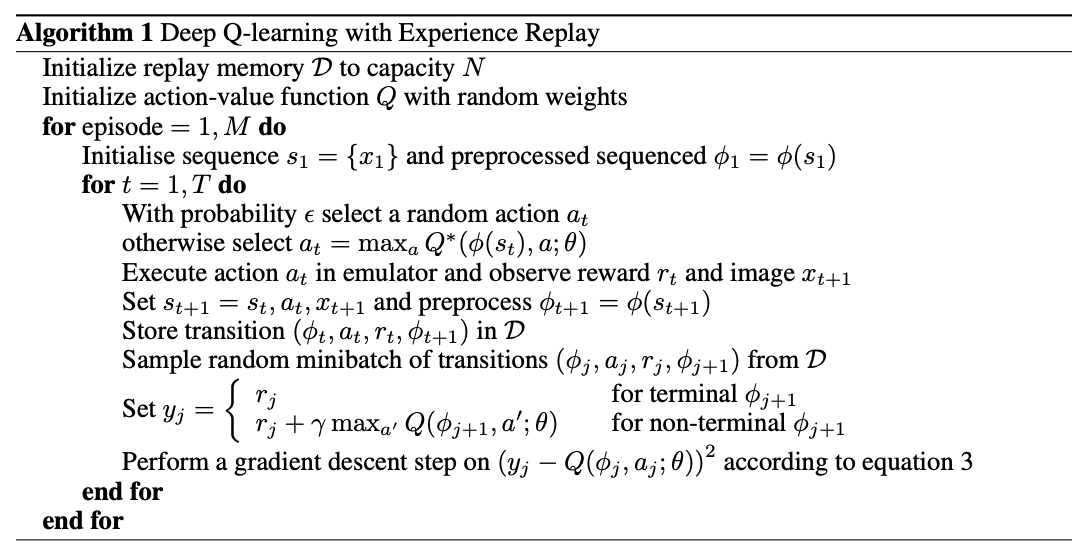

In [2]:
Image(filename='../data/images/experience_replay_algo.png',width=600) 

## Set-Up

### Rubix Cube

The Rubix cube is modelled by the lib.cube.Cube(). The cube's state is represented as a 3x3x3 numpy.ndarray with a unique integer id assigned to each of the cube's 27 pieces (in reality a Rubix cube has 26 pieces which rotate around an axis at the center, but for this formulation an imaginary center piece with id = 13 is used. It should be noted that this piece never changes position). The Cube() class also has 12 action methods for each valid rotation. The cube class also has a .shuffle() method which is parameterized with an integer *num_shuffles*. This method randomly selects one of the 12 action methods and applies it to the cube, then repeats *num_shuffle* times. The .shuffle() method is used to instantiate training examples for the network.



In [3]:
cube = Cube()
cube_methods = [f for f in dir(cube) if (not f.startswith('_')) and not(f =='state')]
print("Cube class methods:")
print(cube_methods)
print()
print("Cube state representation: ")
print(cube.state)
print()
print("Executing down rotation...")
print()
cube.front()
print(cube.state)

Cube class methods:
['back', 'back_p', 'down', 'down_p', 'front', 'front_p', 'func_list', 'left', 'left_p', 'right', 'right_p', 'shuffle', 'up', 'up_p']

Cube state representation: 
[[[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]]

 [[ 9 10 11]
  [12 13 14]
  [15 16 17]]

 [[18 19 20]
  [21 22 23]
  [24 25 26]]]

Executing down rotation...

[[[ 6  3  0]
  [ 7  4  1]
  [ 8  5  2]]

 [[ 9 10 11]
  [12 13 14]
  [15 16 17]]

 [[18 19 20]
  [21 22 23]
  [24 25 26]]]


### Architecture

The architecture of the Q function approximator consists of convolutional layers followed by fully connected layers. First, each cube piece is embedded as a learnable $d_e$-dimension vector using its unique id. The 3x3x3x$d_e$ cube is then followed by $n_c$ 3D-convolutional layers each with a 2x2x2 kernel and $d_c$ filters. Then $n_d$ fully connected layers each of $d_f$-dimension are used. The final layer is also fully connected and has an output dimension of 12.

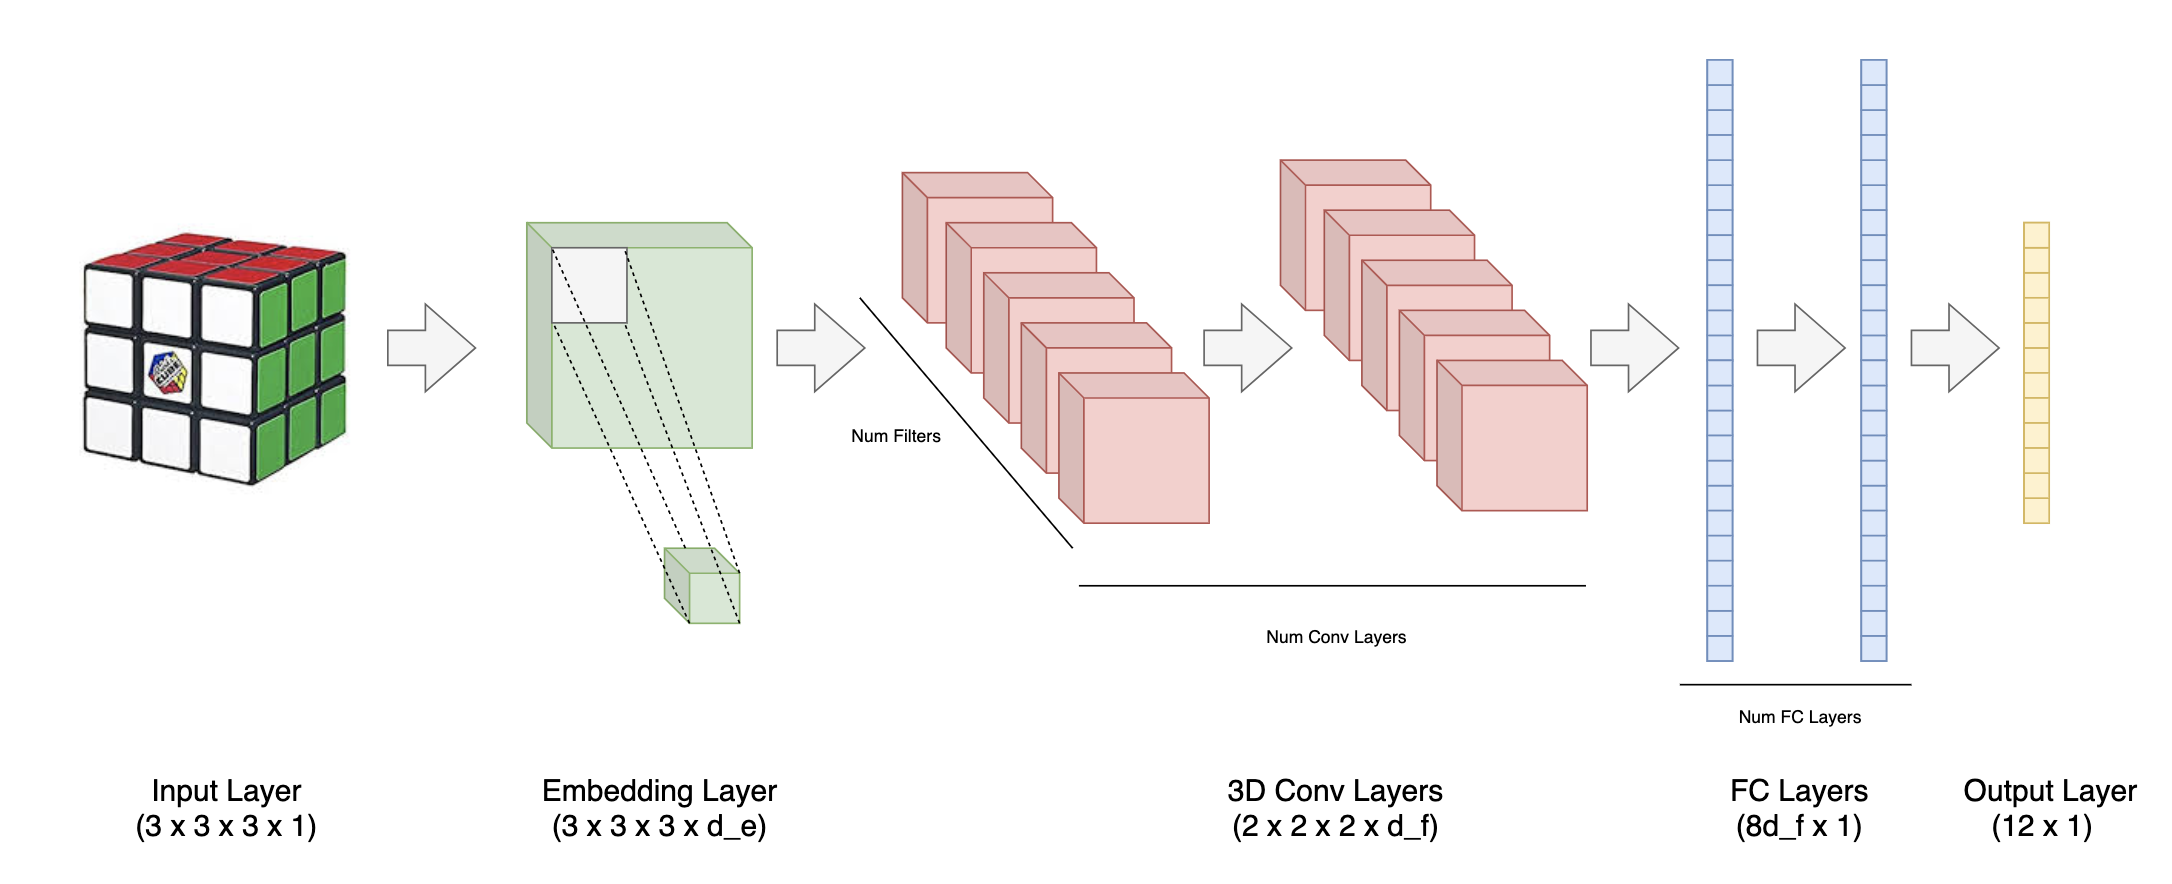

In [4]:
Image(filename='../data/images/model_architecture.png',width=800) 

## Experimentation and Results

To measure the performance of each experiment, three metrics are tracked: the training loss, validation accuracy (of solving a shuffled cube), and the maximum q value for a given state. Training loss use is Mean Squared Error and can be used to measure convergence in the training loop. Validation accuracy is measured every 25 episodes by having the agent attempt to solve 100 shuffled cubes. In addition, every 25 episodes the agent is again shown 100 randomly shuffled cubes and the max Q-value across actions for each of these cubes is averaged together. This last metric is used by [3] as a stable measure of agent performance.

The code for experiments can be found in notebooks/Experimentation.ipynb

### Experiement 1 (Number of Shuffles = 1)

#### Model Architecture: 
Embedding Dimension: 50  
Single Conv Layer with 20 Filters  
Single FC Layer (50-D)  
No Regularization

#### Training Params: 
Num Episodes: 1000  
Learning Rate: 0.001  
Exploration Strategy: Linear Decay Until 0.1 at Episode 100  
Replay Buffer Capacity: 128  
Batch Size: 16  
Discount Factor: .9


The agent is able to succesfully solve a Rubix cube randomly shuffled once.          As is expected training loss decreases, avg max Q value increases, and validation         accuracy converges to 1.

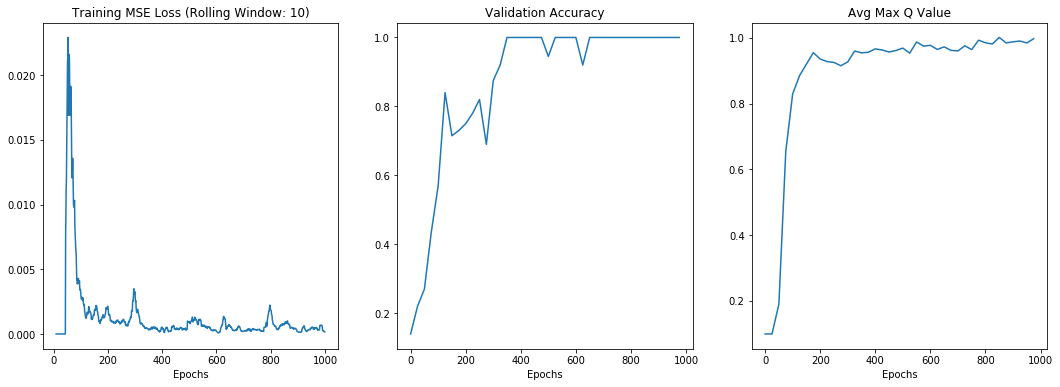

In [5]:

fig, axs = plt.subplots(1,3,figsize=(18,6))

def plot_results(results_name,
                 results_label=None,
                 show_legend=False,
                 plot_dir = '../data/training_metrics', 
                 rolling_window=10):
    loss_path = os.path.join(plot_dir,f'run-gradient_tape_{results_name}_train-tag-loss.csv')
    acc_path = os.path.join(plot_dir,f'run-gradient_tape_{results_name}_train-tag-val_acc.csv') 
    max_q_path = os.path.join(plot_dir,f'run-gradient_tape_{results_name}_train-tag-avg_max_q.csv') 
    train_loss = pd.read_csv(loss_path)
    train_acc = pd.read_csv(acc_path)
    train_max_q = pd.read_csv(max_q_path)


    
    axs[0].plot(train_loss['Step'],train_loss['Value'].rolling(rolling_window).mean(), label=results_label)
    axs[0].set_title("Training MSE Loss (Rolling Window: {})".format(rolling_window))
    axs[0].set_xlabel("Epochs")

    axs[1].plot(train_acc['Step'],train_acc['Value'], label=results_label)
    axs[1].set_title("Validation Accuracy")
    axs[1].set_xlabel("Epochs")

    axs[2].plot(train_max_q['Step'],train_max_q['Value'], label=results_label)
    axs[2].set_title("Avg Max Q Value")
    axs[2].set_xlabel("Epochs")
    
    if show_legend:
        axs[0].legend()
        axs[1].legend()
        axs[2].legend()
        
plot_results('base_model_v2_one_shuffle')

Markdown("The agent is able to succesfully solve a Rubix cube randomly shuffled once. \
         As is expected training loss decreases, avg max Q value increases, and validation\
         accuracy converges to 1.")

### Experiement 2a (Number of Shuffles = 3)

Next, the agent using the architecture from experiment 1 is tested against 3 shuffles and does not perform well as show by the results in blue. Notably, the average max Q value gets stuck at 0, which is indicative of the dying Relu problem. To mitigate this problem and allow the network to recover from negative values, Elu activations [4] are used instead, which result in a performance improvement and modest validation accuracy of ~40%.

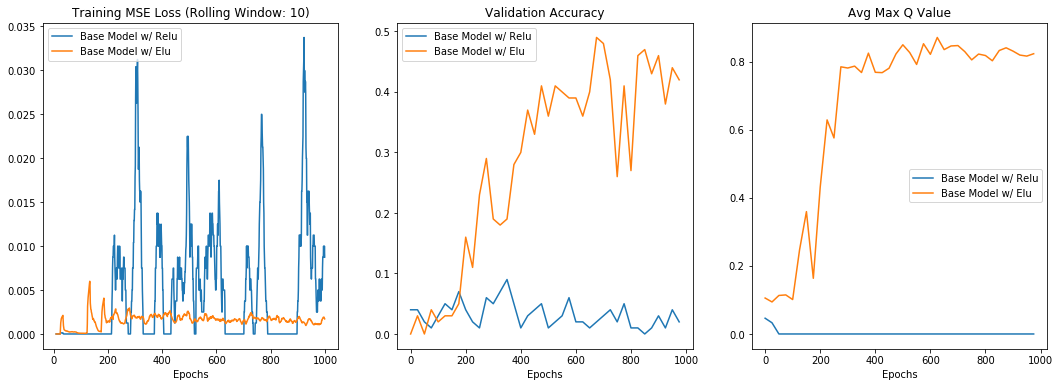

In [6]:
fig, axs = plt.subplots(1,3,figsize=(18,6))

plot_results('base_model_v2_20191414215304',
             results_label='Base Model w/ Relu',
             show_legend=True,
             plot_dir = '../data/training_metrics',
             rolling_window=10)
plot_results('base_model_v2_20191414214652',
             results_label='Base Model w/ Elu',
             show_legend=True,
             plot_dir = '../data/training_metrics',
             rolling_window=10)


Markdown("Next, the agent using the architecture from experiment 1 is tested against 3 shuffles \
and does not perform well as show by the results in blue. Notably, the average max Q value gets stuck at 0, \
which is indicative of the dying Relu problem. To mitigate this problem and allow the network to recover from \
negative values, Elu activations [4] are used instead, which result in a performance improvement and modest validation \
accuracy of ~40%.")


### Experiement 2a (Number of Shuffles = 3)

#### Model Architecture: 
Embedding Dimension: 100  
Three Conv Layer with 50 Filters  
Three FC Layer (50-D)  
Regularization on all layers with regularization constant of .05

#### Training Params: 
Num Episodes: 40000  
Learning Rate: .0001 for 10000 episodes then decreased to 1e-5 until the 30000th episode, and then decreased to 5e-6  
Exploration Strategy: Linear Decay Until 0.1 at Episode 100  
Replay Buffer Capacity: 128  
Batch Size: 16  
Discount Factor: .9

A larger network trained for more episodes is also tested against 3 shuffles. This network achieved an accuracy of ~86%.

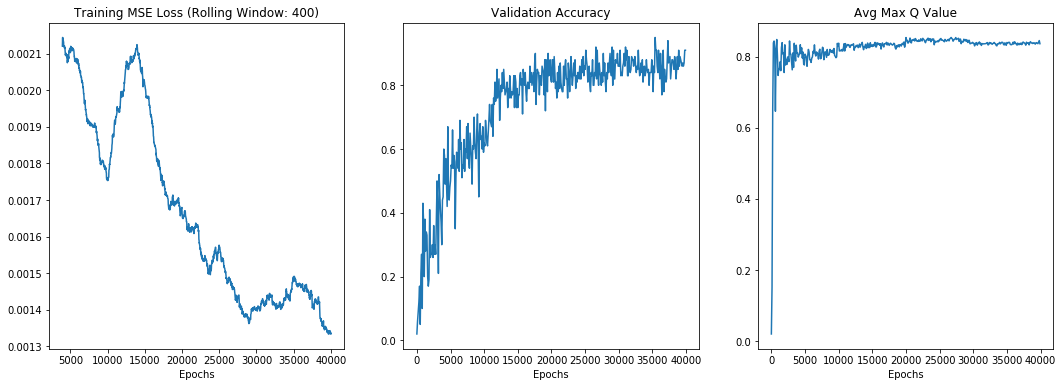

In [18]:
fig, axs = plt.subplots(1,3,figsize=(18,6))

plot_results('base_model_v2_20191818_three_shuffle_40000_epochs',
             show_legend=False,
             plot_dir = '../data/training_metrics',
             rolling_window=400)


Markdown("A larger network trained for more episodes is also tested against 3 shuffles. This network achieved \
an accuracy of ~86%.")


### Future Experiements 

To come are further experiments increasing the number of shuffles, and seeing what adjustments will be needed to help the agent solve these more complex states.

## Deployment

One application of the agent is to deploy it on the back-end of a simple flask app, which can be started from the command line when in the root directory of this repo via:

```
python app.py
```

The front-end Rubix cube emulator is a slightly modified version of the one devloped by Ebin Xavier:
https://github.com/ebinxavier/rubiksCube

Note: To run the app, a trained model with weights must already exist in data/models/ and must be referenced within app.py.

## Sources

[1] https://en.wikipedia.org/wiki/Markov_decision_process


[2] https://en.wikipedia.org/wiki/Universal_approximation_theorem

[3] Mnih, Volodymyr, Kavukcuoglu, Koray, Silver, David,
Graves, Alex, Antonoglou, Ioannis, Wierstra, Daan, and
Riedmiller, Martin. Playing atari with deep reinforcement learning. In NIPS Deep Learning Workshop. 2013.
https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

[4]  Clevert, Djork-Arne, Unterthiner, Thomas and Hochreiter, Sepp. FAST AND ACCURATE DEEP NETWORK LEARNING BY
EXPONENTIAL LINEAR UNITS (ELUS). ICLR 2016. https://arxiv.org/pdf/1511.07289.pdf




